#### Basic LSTM's to classify genres
In this notebook, we configure and train a basic Long Short-Term Memory Networks (LSTM's). 

In [17]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
import math
from collections import Counter

from datasets import load_dataset

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [19]:
# load the data
data_files = {"train": "data/train_data.zip", "test": "data/test_data.zip"}
train_dataset = load_dataset("csv", data_files=data_files["train"])
test_dataset = load_dataset("csv", data_files=data_files["test"])
print(test_dataset)
print(test_dataset['train'][35]['Summary'])  # for some reason you still need to use ['train']

Found cached dataset csv (/Users/jmc/.cache/huggingface/datasets/csv/default-7ea8802e0a5d8de9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 27.69it/s]
Found cached dataset csv (/Users/jmc/.cache/huggingface/datasets/csv/default-cced43b195c555d7/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 85.26it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Wikipedia ID', 'Freebase ID', 'Title', 'Author', 'Publication Date', 'Genres', 'Summary', 'CleanSummary'],
        num_rows: 2519
    })
})
 In October 1921, Andrew Manson, an idealistic, newly qualified doctor, arrives from Scotland to work as assistant to Doctor Page in the small Welsh mining town of 'Drineffy'. He quickly realises that Page is an invalid and that he has to do all the work for a meagre wage. Shocked by the unsanitary conditions he finds, he works to improve matters and receives the support of Dr Philip Denny, a cynical semi-alcoholic. Resigning, he obtains a post as assistant in a miners' medical aid scheme in 'Aberalaw', a neighbouring coal mining town in the South Wales coalfield. On the strength of this job, he marries Christine Barlow, a junior school teacher. Christine helps her husband with his silicosis research. Eager to improve the lives of his patients, mainly coal miners, Manson dedicates

#### Preprocessing:

In [20]:
# tokenize data, keep punctuation for EOS
tokenizer = get_tokenizer('basic_english')
tokenize_data = lambda example, tokenizer: {'tokens': tokenizer(example['Summary'])}  
tokenized_train_dataset = train_dataset.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer})
tokenized_test_dataset = test_dataset.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer})
print(tokenized_test_dataset)
print(tokenized_test_dataset['train'][35]['tokens'])

Loading cached processed dataset at /Users/jmc/.cache/huggingface/datasets/csv/default-7ea8802e0a5d8de9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-544fd189ae847b82.arrow
Loading cached processed dataset at /Users/jmc/.cache/huggingface/datasets/csv/default-cced43b195c555d7/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-7d5765d4a649be26.arrow


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Wikipedia ID', 'Freebase ID', 'Title', 'Author', 'Publication Date', 'Genres', 'Summary', 'CleanSummary', 'tokens'],
        num_rows: 2519
    })
})
['in', 'october', '1921', ',', 'andrew', 'manson', ',', 'an', 'idealistic', ',', 'newly', 'qualified', 'doctor', ',', 'arrives', 'from', 'scotland', 'to', 'work', 'as', 'assistant', 'to', 'doctor', 'page', 'in', 'the', 'small', 'welsh', 'mining', 'town', 'of', "'", 'drineffy', "'", '.', 'he', 'quickly', 'realises', 'that', 'page', 'is', 'an', 'invalid', 'and', 'that', 'he', 'has', 'to', 'do', 'all', 'the', 'work', 'for', 'a', 'meagre', 'wage', '.', 'shocked', 'by', 'the', 'unsanitary', 'conditions', 'he', 'finds', ',', 'he', 'works', 'to', 'improve', 'matters', 'and', 'receives', 'the', 'support', 'of', 'dr', 'philip', 'denny', ',', 'a', 'cynical', 'semi-alcoholic', '.', 'resigning', ',', 'he', 'obtains', 'a', 'post', 'as', 'assistant', 'in', 'a', 'miners', "'", 'medical

In [21]:
# vocab setup
vocab = build_vocab_from_iterator(tokenized_train_dataset['train']['tokens'], min_freq=3) 
vocab.insert_token('<unk>', 0)  # unknown words (if don't know, will return unk)       
vocab.insert_token('<eos>', 1)  # learn End of Sentence
vocab.insert_token('<bos>', 2)
genres = list(set(train_dataset['train']['Genres']).union(test_dataset['train']['Genres']))
for index, genre in enumerate(genres): vocab.insert_token('<{}>'.format(genre), index + 2)           
vocab.set_default_index(vocab['<unk>'])   
print(len(vocab))                         
print(vocab.get_itos()[:10])     

50879
['<unk>', '<eos>', '<Historical fiction>', '<Novel>', '<Alternate history>', '<Gothic fiction>', '<Autobiography>', '<Short story>', '<Biography>', '<Crime Fiction>']


In [22]:
# embed words into batch sizes
def get_data(dataset, vocab, batch_size):
    data = []                                                   
    for example in dataset:
        if example['tokens']:
            # prepend
            tokens = example['tokens'].insert(0, '<{}>'.format(example['Genres']))
            tokens = example['tokens'].insert(0, '<bos>')
            # append                                      
            tokens = example['tokens'].append('<eos>')             
            tokens = [vocab[token] for token in example['tokens']] 
            data.extend(tokens)                                    
    data = torch.LongTensor(data)                                 
    num_batches = data.shape[0] // batch_size 
    data = data[:num_batches * batch_size]                       
    data = data.view(batch_size, num_batches)          
    return data

In [23]:
batch_size = 256
train_data = get_data(tokenized_train_dataset['train'], vocab, batch_size)
test_data = get_data(tokenized_test_dataset['train'], vocab, batch_size)

In [24]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):    
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        

    def forward(self, src, hidden):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)          
        output = self.dropout(output) 
        prediction = self.fc(output)
        return prediction, hidden
    
    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell

In [25]:
vocab_size = len(vocab)
embedding_dim = 128 
hidden_dim = 512             
num_layers = 3
dropout_rate = 0.2                             
lr = 1e-3

In [26]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
# optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 38,130,751 trainable parameters


In [27]:
def get_batch(data, seq_len, num_batches, idx):
    src = data[:, idx:idx+seq_len]                   
    target = data[:, idx+1:idx+seq_len+1]             
    return src, target

In [28]:
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):
    
    epoch_loss = 0
    model.train()
    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)
    
    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):  # The last batch can't be a src
        print('in train')
        optimizer.zero_grad()

        src, target = get_batch(data, seq_len, num_batches, idx)
        src, target = src.to(device), target.to(device)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)               

        prediction = prediction.reshape(batch_size * seq_len, -1)   
        target = target.reshape(-1)
        loss = criterion(prediction, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [29]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, num_batches, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches

In [ ]:
n_epochs = 15
seq_len = 50
clip = 0.25
saved = False
train_ppm = []
train_l = []
test_ppm = []
test_l = []

# lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

if saved:
    model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=device))
    test_loss = evaluate(model, test_data, criterion, batch_size, seq_len, device)
    print(f'Test Perplexity: {math.exp(test_loss):.3f}')
else:
    model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=device))
    best_test_loss = float('inf')

    for epoch in range(n_epochs):
        train_loss = train(model, train_data, None, criterion,  # optimizer
                    batch_size, seq_len, clip, device)
        test_loss = evaluate(model, test_data, criterion, batch_size, 
                    seq_len, device)
        
        # lr_scheduler.step(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), 'best-val-lstm_lm.pt')

        train_l.append(train_loss)
        test_l.append(test_loss)
        train_pp = math.exp(train_loss)
        test_pp = math.exp(test_loss)
        train_ppm.append(train_pp)
        test_ppm.append(test_pp)

        print(f'\tTrain Loss: {train_loss:.3f}\tValidation Loss: {test_loss:.3f}')
        print(f'\tTrain Perplexity: {train_pp:.3f}\tValidation Perplexity: {test_pp:.3f}')

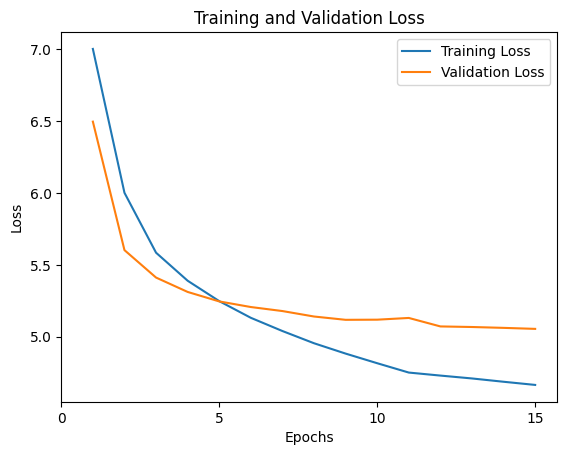

In [56]:
# plot loss
epochs = range(1, 16)

plt.plot(epochs, train_l, label='Training Loss')
plt.plot(epochs, test_l, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
plt.xticks(np.arange(0, 16, 5))
 
plt.legend(loc='best')
plt.savefig('data/lstm_loss.png')
plt.show()

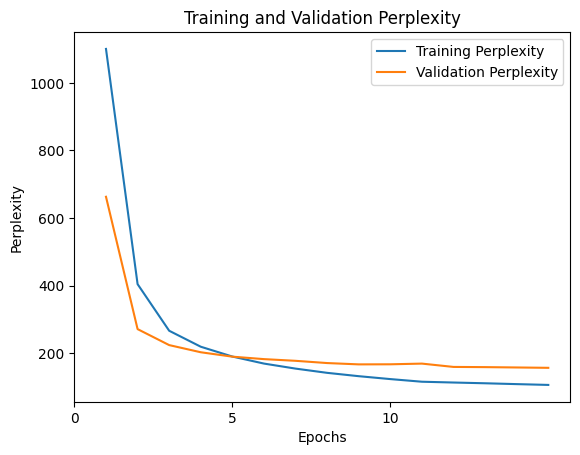

In [58]:
# plot perplexity
epochs = range(1, 16)
 
plt.plot(epochs, train_ppm, label='Training Perplexity')
plt.plot(epochs, test_ppm, label='Validation Perplexity')

plt.title('Training and Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
 
plt.xticks(np.arange(0, 15, 5))
 
plt.legend(loc='best')
plt.savefig('data/lstm_perplexity.png')
plt.show()